In [1]:
# the imports required for this notebook
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import scipy.stats as stats
import sklearn.linear_model
import sklearn.preprocessing
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

import wrangle_module
import model
import viz
import hypothesis_testing

In [2]:
# Wrangling function that creates all dfs, splits, encoding and scaling 
# in one fell swoop.  
permits, copy, train, validate, test, explore, X_train, y_train, X_validate, y_validate, \
X_test, y_test, train_scaled, X_train_scaled, validate_scaled, X_validate_scaled, \
test_scaled, X_test_scaled \
= wrangle_module.wrangle_df()

## clustering here

In [11]:
from sklearn.cluster import KMeans

In [18]:
X_train_scaled.head().T

Permit_approved,2018-11-07,2016-07-11,2016-11-10,2019-09-26,2016-09-26
API_NO.,38937764,46140376,16334012,25536606,17333081
Operator_Name_Number,NOBLE ENERGY INC (611665),APACHE CORPORATION (027200),CABOT OIL & GAS CORPORATION (121700),BPX OPERATING COMPANY (085408),"VERITAS ENERGY, LLC (884589)"
Lease_Name,WILD BILL HICKOK 205-206 UNIT B,CONNELL 48 WEST,THOMPSON RANCH,LONESOME DOVE A,BRYANS 26
Well,9H,2HM,11H,8H,1
District,08,7C,01,02,08
County,REEVES,UPTON,FRIO,KARNES,GLASSCOCK
Wellbore_Profile,Horizontal,Horizontal,Horizontal,Horizontal,Vertical
Filing_Purpose,New Drill,New Drill,New Drill,New Drill,Recompletion
Amend,N,N,N,N,N
Current_Queue,APPROVED,APPROVED,APPROVED,APPROVED,APPROVED


In [13]:
X = X_train_scaled[['Wellbore_Profile', 'Depth_scaled', 'SHALE']]
X.head()

,Wellbore_Profile,Depth_scaled,SHALE
Permit_approved,,,
2018-11-07,Horizontal,0.461235,PERMIAN BASIN
2016-07-11,Horizontal,0.360732,PERMIAN BASIN
2016-11-10,Horizontal,0.292534,EAGLE FORD
2019-09-26,Horizontal,0.420818,EAGLE FORD
2016-09-26,Vertical,0.299713,PERMIAN BASIN


array([[<AxesSubplot:title={'center':'Depth_scaled'}>]], dtype=object)

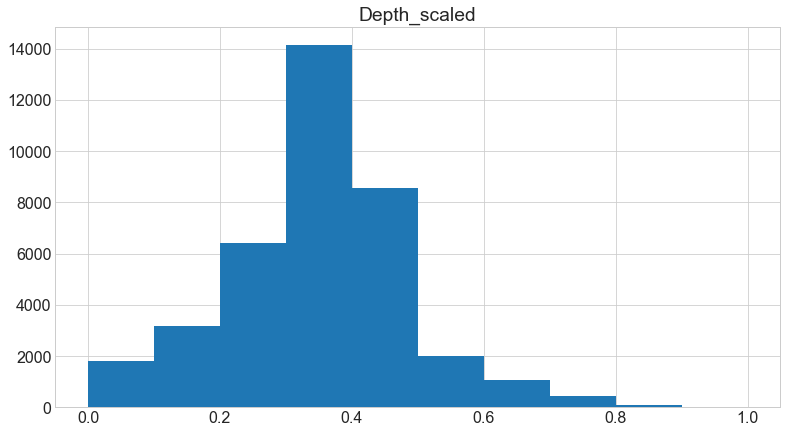

In [14]:
X.hist()

In [17]:
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=5, random_state = 123, verbose = 0)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

ValueError: could not convert string to float: 'Horizontal'

## features here

In [3]:
# drop all rows not being fed into any model/feature selector
X_train_model, X_validate_model, X_test_model = \
model.create_data_for_models(X_train_scaled, X_validate_scaled, X_test_scaled)

In [4]:
model.select_kbest(X_train_model, y_train, 4)

['SHALE_EAGLE FORD', 'SHALE_PERMIAN BASIN', 'District_01', 'District_08']

In [5]:
model.select_rfe(X_train_model, y_train, 4)

['District_01', 'District_02', 'District_05', 'District_06']

In [6]:
# # Create dataframes for modeling purposes from the model module. Just dropping the 
# # appropriate columns according to the model
X_train_kbest, X_validate_kbest, X_test_kbest, X_train_rfe, X_validate_rfe, X_test_rfe \
= model.create_features(X_train_model, X_validate_model, X_test_model)

In [7]:
# add baseline prediction to all y_ dataframes using function in my model file
y_train,y_validate,y_test = model.add_pred_mean(y_train,y_validate,y_test)

In [8]:
# using a function to print the rmse of the model on train and validate, using baseline
rmse_train, rmse_validate = model.get_rmse_in_sample(y_train,y_validate)

RMSE using Mean
Train/In-Sample:  5.6746 
Validate/Out-of-Sample:  5.5954


In [9]:
metric_df = model.create_eval_df(rmse_train, rmse_validate)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,5.674629,5.595407


In [10]:
# assigning and displaying the evaluation df for the various models i've run
# in my model module
metric_df = model.run_all_models(X_train_model, X_train_kbest, X_train_rfe, y_train, 
                                 X_validate_model,X_validate_kbest, X_validate_rfe, 
                                 y_validate, metric_df)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,5.674629,5.595407
1,OLS Regressor all features,5.661146,5.586228
2,OLS Regressor k_best,5.668417,5.592183
3,OLS Regressor rfe,5.665753,5.588958
4,Lasso_alpha1 all features,5.674629,5.595407
5,Lasso_alpha1 k_best,5.674629,5.595407
6,Lasso_alpha1 rfe,5.674629,5.595407
7,glm_compound all features,5.660915,5.585307
8,glm_compound k_best,5.668405,5.592182
9,glm_compound rfe,5.665753,5.588957
